# Forecasting grid-search CV with sktime

[Github weblink](https://github.com/alan-turing-institute/sktime/blob/master/examples/forecasting_gscv.ipynb)

In this tutorial, we run grid-search cross-validation (CV) for forecasting. 

<div class="alert alert-block alert-warning">
<b>Note:</b> This functionality is experimental. Please make sure to install the development version from the forecast branch. Follow these instructions:
    
* `git clone https://github.com/alan-turing-institute/sktime.git`
* `git checkout forecast`
* `git pull` 
* `conda activate <my-env>`
* `pip install -e .` (in the root directory, make sure to follow the more detailed instructions here: https://alan-turing-institute.github.io/sktime/installation.html)
* launch Jupyter notebook from same environment  
</div>

## Preliminaries

In [1]:
from sktime.forecasters.model_selection import ForecastingGridSearchCV
from sktime.forecasters.compose import ReducedTimeSeriesRegressionForecaster
from sklearn.ensemble import RandomForestRegressor
from sktime.pipeline import Pipeline
from sktime.transformers.compose import Tabulariser
from sktime.datasets import load_shampoo_sales
from sktime.forecasters.model_selection import temporal_train_test_split
from sktime.forecasters.model_selection import RollingWindowSplit
from sktime.utils.testing import generate_polynomial_series

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Helper function to plot series
def plot_ts(y_train, y_test=None, y_pred=None):
    fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
    y_train.plot(ax=ax, style="-", label="train")
    if y_test is not None:
        y_test.plot(ax=ax, style="-", label="test")
    if y_pred is not None:
        y_pred.plot(ax=ax, style="-", label="forecast")
    plt.legend()

In [3]:
# generate time series
# y = load_shampoo_sales()
n_timepoints = 100
order = 2
coefs = None
samples = []
s = generate_polynomial_series(n_timepoints, order=order, coefs=coefs)
s = s + np.random.normal(scale=200, size=n_timepoints)
index = np.arange(n_timepoints)
y = pd.Series(s, index=index)

fh = np.arange(10) + 1  # forecasting horizon
y_train, y_test = temporal_train_test_split(y, fh)

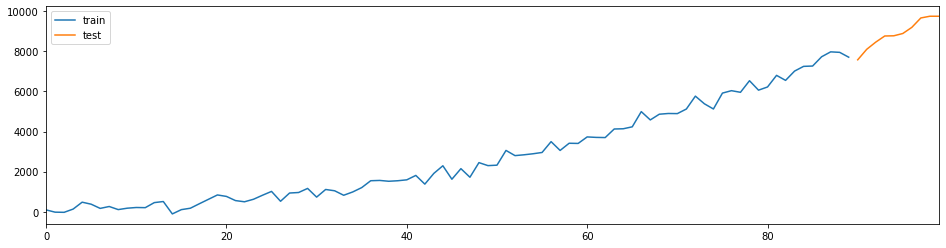

In [4]:
plot_ts(y_train, y_test)

In [5]:
# fh = np.arange(5) + 1
# window_length = 20
# cv = RollingWindowSplit(fh=fh, window_length=window_length)
# for i, (train, test) in enumerate(cv.split(y.index.values)):
#     print(train, test)
# n_splits = cv.get_n_splits()
# print(n_splits)
# assert n_splits == i + 1

In [6]:
# specify time series regressor
ts_regressor = Pipeline([
    ("tabularise", Tabulariser()),
    ("regress", RandomForestRegressor(n_estimators=200))
])

# specify reduction wrapper, solving forecasting via time series regression 
forecaster = ReducedTimeSeriesRegressionForecaster(
    ts_regressor=ts_regressor,
    window_length=5
)
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict()

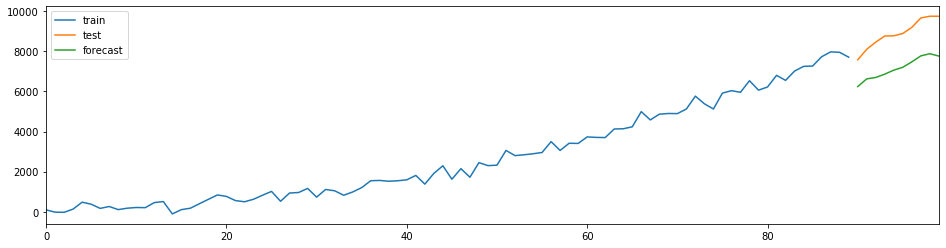

In [7]:
plot_ts(y_train, y_test, y_pred)

In [8]:
param_grid = {"window_length": [5, 10, 20]}
gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=RollingWindowSplit(fh, n_splits=10),
    refit=True
)
gscv.fit(y_train, fh=fh)
print(gscv.best_params_)

{'window_length': 5}


In [9]:
pd.DataFrame(gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_window_length,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.645251,0.005352,0.110142,0.015552,5,{'window_length': 5},-0.300187,-0.296102,-0.270594,-0.266016,-0.267171,-0.259022,-0.258138,-0.263230,-0.253949,-0.254017,-0.268843,0.015568,1
1,1.689811,0.021342,0.105846,0.004538,10,{'window_length': 10},-0.298307,-0.298923,-0.274290,-0.265073,-0.272641,-0.259759,-0.260943,-0.263934,-0.257780,-0.253753,-0.270540,0.015237,2
2,1.749538,0.049466,0.107188,0.009093,20,{'window_length': 20},-0.308206,-0.307446,-0.277317,-0.271177,-0.274188,-0.265452,-0.267548,-0.270758,-0.260563,-0.256399,-0.275905,0.016991,3


In [10]:
fcv = gscv.get_params()["cv"]
rfcv = gscv.best_forecaster_.rw
print(fcv.window_length_, fcv.n_splits_)
print(rfcv.window_length_, rfcv.n_splits_)

71 10
5 76


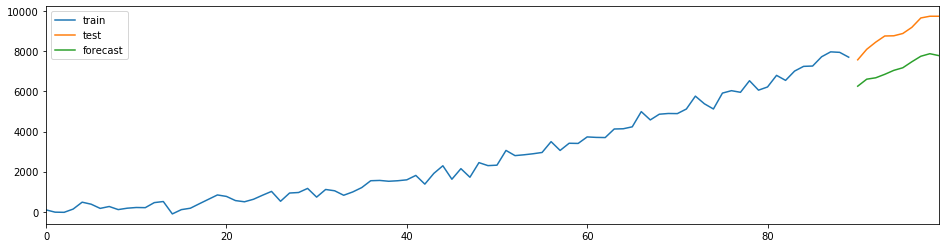

In [11]:
y_pred = gscv.predict()
plot_ts(y_train, y_test, y_pred)